In [1]:

from keras.datasets import imdb
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
data = pd.read_csv("IdeologyBills.csv")

In [4]:
#print('texts: ', data['text'].to_numpy()[:3])
#print()
#print('labels: ', data['Ideology'].to_numpy()[:3])

In [5]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(lambda a: re.sub('[^a-zA-z0-9\s]','',a))
data['text'] = data['text'].str.replace('[{}]'.format(string.punctuation), ' ')

/var/folders/jn/grz4j9xj2dd9pq6p41gbk1j00000gn/T/ipykernel_40388/1785652629.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('[{}]'.format(string.punctuation), ' ')


In [6]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,output_sequence_length=3000)

npTexts = data['text'].to_numpy()
#npTexts = np.array(list(map(lambda a: np.flatten(a),npTexts)))
npTexts = npTexts.reshape(len(npTexts))
encoder.adapt(npTexts)
print(encoder(npTexts[2]))

2022-12-09 01:51:46.163664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor([  5 410  57 ...   0   0   0], shape=(3000,), dtype=int64)


In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'and', 'to', 'in', 'a', 'for', 'or',
       'by', 'section', 'as', 'such', 'shall', 'on', 'under', 'is',
       'that', 'act'], dtype='<U22')

In [8]:
example = data['text']
encoded_example = encoder(example).numpy()
len(encoded_example[0])

3000

In [9]:
for n in range(3):
  #print("Original: ", example[n])
  #print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

In [10]:
len(encoder.get_vocabulary())

5000

In [37]:
GloVe_file = '/Users/lucasgover/Downloads/glove.6B/glove.6B.50d.txt'

In [38]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [40]:
vocab_len = len(encoder.get_vocabulary())
embed_vector_len = 50
word_to_vec_map = read_glove_vector(GloVe_file)

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word,index in zip(encoder.get_vocabulary(),range(len(encoder.get_vocabulary()))):
  print(word)
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

KeyboardInterrupt: 

In [11]:
model = keras.models.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))


In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


[0.00067044]


In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


[0.00067044]


In [15]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=keras.metrics.MeanSquaredError())


In [16]:
X = npTexts
y = data['Ideology'].to_numpy()
X_train, X_test,Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 45)

In [18]:
history = model.fit(X_train,Y_train, epochs=1,validation_data=(X_test,Y_test),validation_steps=30)

74/74 [==============================] - 173s 2s/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0624 - val_mean_squared_error: 0.0624


In [ ]:
#model.save('~/model_12/8ish')

In [19]:
test_loss, test_acc = model.evaluate(X_train,Y_train)


print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

74/74 [==============================] - 33s 438ms/step - loss: 0.0264 - mean_squared_error: 0.0264
Test Loss: 0.026433808729052544
Test Accuracy: 0.026433808729052544


In [24]:
history.history

{'loss': [0.038434747606515884],
 'mean_squared_error': [0.038434747606515884],
 'val_loss': [0.06241213157773018],
 'val_mean_squared_error': [0.06241213157773018]}

(0.0, 0.0636110007762909)

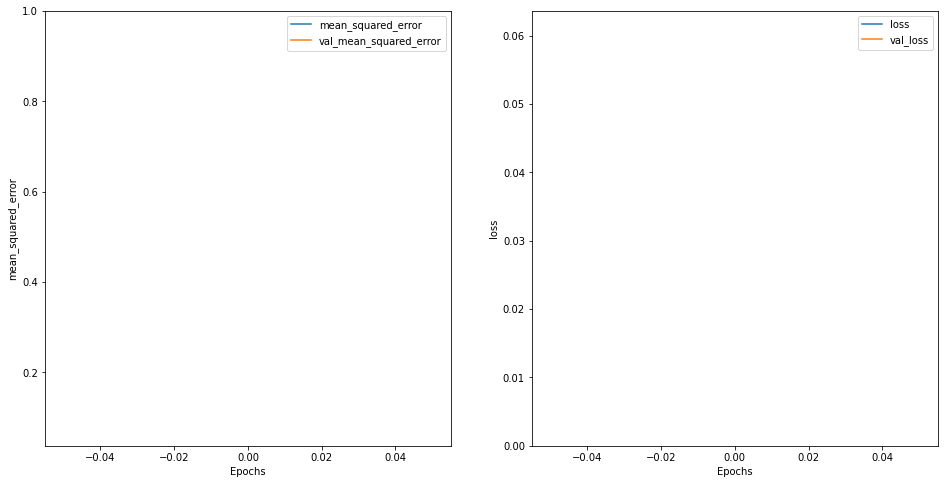

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mean_squared_error')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [28]:
predictions = model.predict(X)

num_correct = 0
for i,j,k in zip(predictions,y,X):
    if (i > 0 and j > 0) or (i < 0 and j < 0):
        num_correct += 1
    else:
        print(encoder(k[:3000]).numpy())
print(num_correct / len(predictions))

[  5 410  57 ...   0   0   0]
[   5  147 3742 ...    0    0    0]
[  5 344   2 ...   0   0   0]
[  5 147  39 ...   0   0   0]
[5 1 2 ... 0 0 0]
[  5 410   2 ...   0   0   0]
[  5 147  11 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 970   2 ...   0   0   0]
[  5 344   2 ...   0   0   0]
[1023    2  677 ...    0    0    0]
[ 626    2 1067 ...    0    0    0]
[  5 344   2 ...   0   0   0]
[3022   15    2 ...    0    0    0]
[  5 147   2 ...   0   0   0]
[  5 147  39 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 147  39 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 247  18 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 226   2 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 109   8 ...   0   0   0]
[  5 344   2 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 344   2 ...   0   0   0]
[   5 2434    2 ...    0    0    0]
[  5 147  39 ...   0   0   0]
[  5 147   2 ...   0   0   0]
[  5 147  39 ...   0  

In [36]:
sample_text = ('in this modern age, guns should not have a gender, genders are for people')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.0980597]], dtype=float32)